In [1]:
# @title Copyright 2020 The Cirq Developers
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum approximate optimization algorithm for the Ising model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/qaoa/qaoa_ising"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/qaoa/qaoa_ising.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/qaoa/qaoa_ising.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/qaoa/qaoa_ising.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This notebook provides an introduction to the Quantum Approximate Optimization Algorithm (QAOA) using Cirq. The presentation mostly follows [Farhi et al](https://arxiv.org/abs/1411.4028). We will show how to construct the QAOA circuit and use it to solve optimization problems.

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install cirq --quiet
    import cirq

    print("installed cirq.")

In [3]:
from typing import Sequence, Tuple
import numpy as np
import sympy
import matplotlib.pyplot as plt

## Description of the QAOA

Suppose we have a function $C(z)$ which we want to minimize. Here, $z$ denotes a collection of variables $z = z_1,z_2,\ldots, z_n$, where each $z_j$ can be either $+1$ or $-1$. (The important thing here is that each $z_j$ has *two possible values*. By convention, we choose those values to be $\pm 1$). The QAOA is a general-purpose algorithm whose goal is to produce an assignment of the $z_j$ that gives a relatively low value of $C(z)$. It's not guaranteed to give the lowest possible value of $C(z)$ (hence "approximate" in the name) except in a particular limit which we will discuss.

The QAOA acts on $n$ qubits where, as you might guess, each qubit represents one of the variables $z_1, ..., z_n$, and the $2^n$ states of the computational basis correspond to the $2^n$ possible assignments of the $z$ variables. To be more specific, let's agree that the value of $z_j$ corresponds to the measurement outcome of the Pauli-$Z$ operator on the $j$th qubit. (There is a potential confusion here because the state $| 0 \rangle$ corresponds to $z = +1$, while the state $| 1\rangle$ corresponds to $z=-1$. This is unfortunate, but is something that we'll just have to deal with.)

The QAOA is fairly simple to explain, though the reasons behind why it works are not obvious at first glance. As usual, we begin with all of our qubits initialized in the $|0\rangle$ state. The first step is to act with $H^{\otimes n}$, the Hadamard operator on each qubit. This prepares an equal superposition of all bitstrings, i.e., an equal superposition of all possible $z$ assignments:

$$
H^{\otimes n} |0^n\rangle =\frac{1}{2^{n/2}} \sum_{z \in \{0,1\}^n} |z\rangle.
$$

This should be thought of as the "real" initial state of the algorithm (as opposed to thinking of the $|0\rangle$ state as the initial state). The point of the remaining steps is to affect the amplitudes such that those with small $C(z)$ values grow while those with large $C(z)$ values shrink. In this way, when we measure the qubits we'll be more likely to find a bitstring with a small value of $C(z)$.

The meat of the algorithm relies on the following unitary operator:

$$
U(\gamma, C) = e^{i \pi \gamma C(Z) / 2} .
$$

This operator deserves some explanation. First, $\gamma$ is a parameter which we will later treat as a variational parameter, adjusting its value to produce the best possible result. $C$ here is the function we are trying to minimize, and the notation $C(Z)$ is supposed to tell you to plug in the Pauli-$Z$ operator for each qubit in place of the argument $z$. For example, if 

$$
C(z) = 3z_1 z_2 - z_2z_3 + z_4 ,
$$

then

$$
C(Z) = 3Z_1 Z_2 - Z_2Z_3 + Z_4.
$$

It doesn't look like much happened, but the point here is that $C(z)$ is a number while $C(Z)$ is a matrix. That matrix is diagonal in the computational basis, and those diagonal entries represent all the possible values of $C(z)$.

After acting with $H^{\otimes n}$, we act with $U(\gamma, C)$. The result is still a sum over all possible bit-strings, but now the coefficients are complex phases which depend on $C$. At this point there is still an equal probability to measure any particular string, though, because Born's rule only depends on the square of the amplitude. So, the algorithm is not done yet.

The next step of the algorithm is to act with the unitary operator

$$
U(\beta,B) = e^{i\pi\beta B/2},~~~ B = \sum_{j=1}^n X_j ,
$$

where $\beta$ is another variational parameter. Since the Pauli-$X$ operators on each qubit commute with each other, we can alternatively write this as

$$
U(\beta, B) = \prod_{j=1}^n e^{i\pi\beta X_j/2} .
$$

So this is just a rotation of each qubit around the $X$-axis on the Bloch sphere by an amount determined by $\beta$. This operation is _not_ diagonal in the computational basis, and the resulting state will not be an equal superposition over all bitstrings. So after this step there will be constructive and destructive interference, which hopefully leads to enhancement of states corresponding to small values of $C$. This $U(\beta, B)$ is sometimes called a "mixing" operation. Note that, up to an inconsequential global phase, we can also write

$$
U(\beta, B) = \prod_{j=1}^n X_j^{\beta} .
$$

The total circuit consists of repeating the previous two steps a total of $p\geq 1$ times, where the choice of $p$ is up to you. The parameters $\gamma$ and $\beta$ can be chosen independently at each step. So at the conclusion of the circuit, the state of the qubits is

$$
|\gamma,\beta\rangle = U(\beta_p,B)U(\gamma_p,C)\cdots U(\beta_1,B)U(\gamma_1,C)H^{\otimes n}|0^n\rangle.
$$

If we choose $\gamma$ and $\beta$ so that the expectation value

$$
F(\gamma,\beta) = \langle \gamma,\beta|C(Z)|\gamma,\beta\rangle
$$

is minimized, then measuring the state $|\gamma,\beta\rangle$ in the computational basis gives us a good candidate bitstring for the minimum of $C(z)$. That's the whole thing!

In summary we have to perform the following tasks in order to implement the QAOA:

1.   Figure out how to perform the $U(\gamma, C)$ operation in Cirq for our choice of $C$.
2.   Create a quantum circuit alternating $U(\gamma, C)$ and $U(\beta, B)$ operations as many times as desired. 
3.   Find the optimal value of the variational parameters in our circuit.
4.   Measure the output of our circuit.

## Toy problem: Ground state of the Ising model

The Ising Model defines the energy function

$$
E = -\sum_{\langle i,j \rangle} Z_i Z_j - \sum_i h_i Z_i,
$$

where the notation $\langle i,j\rangle$ means a sum over all nearest-neighbor pairs. The picture here is that the qubits live on the vertices of a graph, and the edges of the graph define which qubits are neighbors. We'll just take our graph to be a rectangular lattice with some number of rows and some number of columns. The numbers $h_i$ have the physical interpretation of an external magnetic field.

We are interested in finding a low-lying state of the Ising Model, by which we mean a state that has a relatively low amount of energy. This is a difficult problem in general. The pairwise interaction terms would tell you that neighboring qubits should be in the same state to lower the energy, while the magnetic field terms tell you that a given qubit wants to point "in the same direction" as its local field, and the strength of that preference depends on the magnitude of the field. These two different kinds of pressure are not always in agreement!

This type of problem is a perfect candidate for the QAOA, where we use the energy $E$ as our cost function $C$.

### Implementing $U(\gamma, C)$

The first thing we need to do is create the operation $U(\gamma, C)$ where $C$ is equal to the Ising model energy function. Note that since all terms in the energy function commute, we can decompose this operation as

$$
U(\gamma, C) = \prod_{\langle i,j\rangle}e^{-i\pi\gamma Z_iZ_j/2} \prod_i e^{-i\pi \gamma h_i Z_i/2}.
$$

This requires that we have the two-qubit gate $\exp(-i\pi\gamma ZZ/2)$ at our disposal. In matrix form, this is

$$
\begin{align}
\exp(-i \pi\gamma Z\otimes Z/2) = \begin{bmatrix}
e^{-i\pi \gamma/2}  & 0  &0&0\\
0 & e^{i\pi \gamma/2}   &0&0\\
0&0& e^{i\pi \gamma/2}  &0 \\
0&0 & 0  & e^{-i\pi \gamma/2}
\end{bmatrix}
\end{align}
$$

Cirq has a built-in gate `cirq.ZZ` which is equivalent to this once you account for a global phase.

In [4]:
"""Example of using the ZZ gate."""
# Get two qubits.
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

# Pick a value for gamma.
gamma = 0.3

# Display the circuit.
circuit = cirq.Circuit(cirq.ZZ(a, b) ** gamma)
print(circuit)

a: ───ZZ───────
      │
b: ───ZZ^0.3───


We should also check that the unitary is what we expect.

In [5]:
"""Check the unitary of the ZZ gate."""
# Unitary we want to implement.
expected_unitary = np.array(
    [
        [np.exp(-1j * np.pi * gamma / 2), 0, 0, 0],
        [0, np.exp(1j * np.pi * gamma / 2), 0, 0],
        [0, 0, np.exp(1j * np.pi * gamma / 2), 0],
        [0, 0, 0, np.exp(-1j * np.pi * gamma / 2)],
    ]
)

# Unitary we are implementing.
actual_unitary = cirq.unitary(circuit)

# Check that they are equal up to global phase.
cirq.testing.assert_allclose_up_to_global_phase(
    actual_unitary, expected_unitary, atol=1e-5
)

The magnetic field terms can be handled in a similar way. The single-qubit unitary

$$
\exp(-i\pi \gamma hZ/2) = \begin{bmatrix}
e^{-i\pi \gamma h/2} & 0 \\
0 & e^{i\pi \gamma h/2}
\end{bmatrix}
$$

is equivalent to `cirq.Z**(h*gamma)` up to global phase.

In [6]:
"""Example of using the Z gate."""
# Value of the external magenetic field.
h = 1.3

# Display the circuit.
circuit = cirq.Circuit(cirq.Z(a) ** (gamma * h))
print(circuit)

a: ───Z^0.39───


As before, we can check this unitary is what we expect.

In [7]:
"""Check the unitary of the Z gate."""
# Unitary we want to implement.
expected_unitary = np.array(
    [[np.exp(-1j * np.pi * gamma * h / 2), 0], [0, np.exp(1j * np.pi * gamma * h / 2)]]
)

# Unitary we are implementing.
actual_unitary = cirq.unitary(circuit)

# Check that they are equal up to global phase.
cirq.testing.assert_allclose_up_to_global_phase(
    expected_unitary, actual_unitary, atol=1e-5
)

Now that we know how to implement both $Z_i Z_j$ and $Z_i$, we can implement the full $U(\gamma, C)$ operator.

### Exercise: More general two-qubit gate

The Ising Model is particularly simple because the nearest-neighbor interaction $Z_i Z_j$ is already given in terms of a product of Pauli matrices. But suppose instead that the cost function was a sum of terms that looked like

$$
C(z_i,z_j) = \begin{cases}
c_{00} \text{ if } z_i =1,~z_j=1,\\
c_{01} \text{ if } z_i =1,~z_j=-1,\\
c_{10} \text{ if } z_i =-1,~z_j=1,\\
c_{11} \text{ if } z_i =-1,~z_j=-1 
\end{cases}
$$

for some numbers $c_{ab}$. How would you make the analogous two-qubit gate for this case? You can either make a custom gate from scratch, or build a solution from the standard elementary gates.

In [8]:
# Your code here!

### Implementing the full circuit

We will focus on the Ising model on a rectangular lattice with an arbitrary number of rows and columns. Here are some things to think about:

1.   `cirq.GridQubit`s are natural because our qubits actually do live on a grid. Cirq does not care what kind of qubit you make, though.
2.   It's a good idea to define separate functions to place the C and B layers for the circuit. Really these should be generators that yield the required gates.
3.   You might consider wrapping everything inside a class. We won't do that here, but if you want to play around with different numbers of rows/columns or different numbers of B/C layers it can be convenient.

First, we'll define the basic parameters of our model and the generators for the different layers.

In [9]:
"""Define problem parameters and get a set of GridQubits."""
# Set the dimensions of the grid.
n_cols = 3
n_rows = 3

# Set the value of the external magnetic field at each site.
h = 0.5 * np.ones((n_rows, n_cols))

# Arranging the qubits in a list-of-lists like this makes them easy to refer to later.
qubits = [[cirq.GridQubit(i, j) for j in range(n_cols)] for i in range(n_rows)]

In [10]:
def gamma_layer(gamma_value: float, h: np.ndarray) -> Sequence[cirq.Operation]:
    """Generator for U(gamma, C) layer of QAOA

    Args:
        gamma: Float variational parameter for the circuit
        h: Array of floats of external magnetic field values
    """
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows - 1:
                yield cirq.ZZ(qubits[i][j], qubits[i + 1][j]) ** gamma_value
            if j < n_cols - 1:
                yield cirq.ZZ(qubits[i][j], qubits[i][j + 1]) ** gamma_value
            yield cirq.Z(qubits[i][j]) ** (gamma_value * h[i, j])

In [11]:
def beta_layer(beta_value: float) -> Sequence[cirq.Operation]:
    """Generator for U(beta, B) layer (mixing layer) of QAOA"""
    for row in qubits:
        for qubit in row:
            yield cirq.X(qubit) ** beta_value

Let's test these functions by constructing the circuit. Try making a circuit with different numbers of layers. How would you automatically make a circuit with a specified number of layers? Make sure the parameters of these layers are distinct `sympy.Symbol`s for later optimization. Print the circuit to see that it's doing what you want it to do.

In [12]:
"""Create the QAOA circuit."""
# Use sympy.Symbols for the 𝛾 and β parameters.
gamma = sympy.Symbol("𝛄")
beta = sympy.Symbol("β")

# Start in the H|0> state.
qaoa = cirq.Circuit(cirq.H.on_each(qubits))

# Your code here!

# Display the QAOA circuit.
qaoa

(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───

(1, 0): ───H───

(1, 1): ───H───

(1, 2): ───H───

(2, 0): ───H───

(2, 1): ───H───

(2, 2): ───H───

#### Solution

We'll just illustrate the solution for a single $C$ layer and a single $B$ layer.

In [13]:
"""Create the QAOA circuit."""
# Use sympy.Symbols for the 𝛾 and β parameters.
gamma = sympy.Symbol("𝛄")
beta = sympy.Symbol("β")

# Start in the H|0> state.
qaoa = cirq.Circuit(cirq.H.on_each(qubits))

# Implement the U(gamma, C) operator.
qaoa.append(gamma_layer(gamma, h))

# Implement the U(beta, B) operator.
qaoa.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

# Display the QAOA circuit.
qaoa

┌──────────────────┐               ┌──────────────────┐
(0, 0): ───H───ZZ───────ZZ───────Z^(0.5*𝛄)──────────────────────────────────────────────────────────────────────────────────────────────X^(β)───
               │        │
(0, 1): ───H───┼────────ZZ^(𝛄)───ZZ──────────ZZ────────Z^(0.5*𝛄)────────────────────────────────────────────────────────────────────────X^(β)───
               │                 │           │
(0, 2): ───H───┼─────────────────┼───────────ZZ^(𝛄)────ZZ────────────────────Z^(0.5*𝛄)──────────────────────────────────────────────────X^(β)───
               │                 │                     │
(1, 0): ───H───ZZ^(𝛄)───ZZ───────┼───────────ZZ────────┼────────Z^(0.5*𝛄)───────────────────────────────────────────────────────────────X^(β)───
                        │        │           │         │
(1, 1): ───H────────────┼────────ZZ^(𝛄)──────ZZ^(𝛄)────┼────────ZZ───────────ZZ───────────Z^(0.5*𝛄)─────────────────────────────────────X^(β)───
                        │                              │        │            │
(1, 2): ───H────────────┼──────────────────────────────ZZ^(𝛄)───┼────────────ZZ^(𝛄)───────ZZ────────────────────Z^(0.5*𝛄)───────────────X^(β)───
                        │                                       │                         │
(2, 0): ───H────────────ZZ^(𝛄)──────────────────────────────────┼────────────ZZ───────────┼────────Z^(0.5*𝛄)────────────────────────────X^(β)───
                                                                │            │            │
(2, 1): ───H────────────────────────────────────────────────────ZZ^(𝛄)───────ZZ^(𝛄)───────┼─────────────────────ZZ──────────Z^(0.5*𝛄)───X^(β)───
                                                                                          │                     │
(2, 2): ───H──────────────────────────────────────────────────────────────────────────────ZZ^(𝛄)────────────────ZZ^(𝛄)──────Z^(0.5*𝛄)───X^(β)───
                                                      └──────────────────┘               └──────────────────┘

### Computing the energy

To train the QAOA circuit (that is, find the optimal values of the parameters) we're going to need to be able to compute the expectation value of the Ising model energy.

If we were using real hardware, the only way to compute the expectation value of the energy would be to estimate it by sampling. Using a simulator we can alternatively compute the wavefunction and then calculate the expectation value from that. Not only does this save us from having to worry about statistical error, it also tends to be faster that simulating the sampling process.

We divide the total energy by the number of qubits because we expect the energy to scale with the size of the system.

In [14]:
def energy_from_wavefunction(wf: np.ndarray, h: np.ndarray) -> float:
    """Computes the energy-per-site of the Ising model directly from the
    a given wavefunction.

    Args:
        wf: Array of size 2**(n_rows * n_cols) specifying the wavefunction.
        h: Array of shape (n_rows, n_cols) giving the magnetic field values.

    Returns:
        energy: Float equal to the expectation value of the energy per site
    """
    n_sites = n_rows * n_cols

    # Z is an array of shape (n_sites, 2**n_sites). Each row consists of the
    # 2**n_sites non-zero entries in the operator that is the Pauli-Z matrix on
    # one of the qubits times the identities on the other qubits. The
    # (i*n_cols + j)th row corresponds to qubit (i,j).
    Z = np.array(
        [(-1) ** (np.arange(2**n_sites) >> i) for i in range(n_sites - 1, -1, -1)]
    )

    # Create the operator corresponding to the interaction energy summed over all
    # nearest-neighbor pairs of qubits
    ZZ_filter = np.zeros_like(wf, dtype=float)
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows - 1:
                ZZ_filter += Z[i * n_cols + j] * Z[(i + 1) * n_cols + j]
            if j < n_cols - 1:
                ZZ_filter += Z[i * n_cols + j] * Z[i * n_cols + (j + 1)]

    energy_operator = -ZZ_filter - h.reshape(n_sites).dot(Z)

    # Expectation value of the energy divided by the number of sites
    return np.sum(np.abs(wf) ** 2 * energy_operator) / n_sites

We'll also need a helper function that computes the expected value of the energy given some parameters of the QAOA.

In [17]:

def energy_from_params(
    gamma_value: float, beta_value: float, qaoa: cirq.Circuit, h: np.ndarray, display) -> float:
    """Returns the energy given values of the parameters."""
    sim = cirq.Simulator()
    params = cirq.ParamResolver({"𝛄": gamma_value, "β": beta_value})
    wf = sim.simulate(qaoa, param_resolver=params).final_state_vector
    if (display):
        print(wf)
    return energy_from_wavefunction(wf, h)

### Optimizing the parameters

Now we need to figure out the best values of $\gamma$ and $\beta$ by minimizing the expectation value of the energy. We'll start by doing a brute-force search of the parameter space for illustrative purposes.

In [18]:
"""Do a grid search over values of 𝛄 and β."""
# Set the grid size and range of parameters.
grid_size = 50
gamma_max = 2
beta_max = 2
# Do the grid search.
energies = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        if (i == 1 and j == 1):
            display = True
        else:
            display = False
        energies[i, j] = energy_from_params(
            i * gamma_max / grid_size, j * beta_max / grid_size, qaoa, h, display
        )

[0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j 0.04419417+0.j
 0.04419417+0.j 0.044194

[0.07610564+0.03471439j 0.05521527+0.03904568j 0.04747823+0.03868874j
 0.04575752+0.04104441j 0.05521527+0.03904567j 0.0374602 +0.03876147j
 0.04575753+0.04104441j 0.0430486 +0.04274046j 0.04747823+0.03868875j
 0.04575753+0.04104441j 0.02572173+0.03513181j 0.03594979+0.04071392j
 0.03187469+0.03798907j 0.02976314+0.03903923j 0.02413611+0.03657027j
 0.03342098+0.04205374j 0.04093438+0.03852692j 0.02596324+0.03569091j
 0.03332871+0.03911363j 0.03047548+0.03964271j 0.02596324+0.03569091j
 0.01451627+0.03079257j 0.03047547+0.0396427j  0.02727605+0.03948098j
 0.03332869+0.03911363j 0.03047546+0.03964271j 0.02528576+0.03774055j
 0.03421283+0.04273981j 0.02003301+0.03516455j 0.01739936+0.03458517j
 0.02275299+0.03804387j 0.03073724+0.04276858j 0.04747823+0.03868873j
 0.03187468+0.03798907j 0.02572173+0.03513181j 0.02413611+0.03657026j
 0.04575752+0.04104441j 0.02976314+0.03903923j 0.03594979+0.04071391j
 0.03342098+0.04205374j 0.02616061+0.03567645j 0.02453217+0.03712132j
 0.01119192+0.028304

[-0.07118788-0.00914085j -0.06095905+0.01859402j -0.05896024+0.0299503j
 -0.04131985+0.02223617j -0.06095904+0.01859402j -0.04733046+0.03806336j
 -0.04131984+0.02223617j -0.03373607+0.01423558j -0.05896024+0.02995031j
 -0.04131985+0.02223617j -0.03726966+0.05833224j -0.03590018+0.02326019j
 -0.0350449 +0.0480488j  -0.02765328+0.03690625j -0.02494439+0.0448795j
 -0.02961854+0.01892576j -0.04934465+0.04098835j -0.03239838+0.05592594j
 -0.02568796+0.04082729j -0.0258507 +0.03110887j -0.03239839+0.05592594j
 -0.01458689+0.06788637j -0.0258507 +0.03110888j -0.03082728+0.02627843j
 -0.02568796+0.04082729j -0.02585071+0.03110888j -0.01730563+0.03736373j
 -0.02693537+0.01621187j -0.00956894+0.05044462j -0.01604026+0.04301842j
 -0.01840407+0.03302737j -0.02909476+0.01505108j -0.05896025+0.0299503j
 -0.0350449 +0.0480488j  -0.03726965+0.05833224j -0.02494438+0.0448795j
 -0.04131984+0.02223619j -0.02765328+0.03690623j -0.03590018+0.02326019j
 -0.02961853+0.01892575j -0.03156954+0.05544145j -0.019

[ 4.91154986e-03-0.01835624j -6.30317349e-03-0.02397147j
 -1.30639896e-02-0.02590203j -1.78925097e-02-0.01317345j
 -6.30317349e-03-0.02397146j -1.96483694e-02-0.02460111j
 -1.78925116e-02-0.01317344j -1.43902339e-02-0.00223674j
 -1.30639840e-02-0.02590203j -1.78925097e-02-0.01317345j
 -4.08057310e-02-0.02762772j -1.65725369e-02-0.00517525j
 -3.75589281e-02-0.02114083j -3.21026333e-02-0.00702299j
 -4.11663763e-02-0.00664021j -1.23743080e-02-0.00059656j
 -2.78470293e-02-0.0237733j  -4.84873988e-02-0.02029817j
 -4.38142382e-02-0.00773599j -3.06364782e-02+0.00114428j
 -4.84873950e-02-0.02029816j -7.29378685e-02-0.01707623j
 -3.06364819e-02+0.00114429j -1.43968901e-02-0.00128206j
 -4.38142307e-02-0.00773599j -3.06364819e-02+0.00114429j
 -4.67207246e-02+0.00785966j -1.18657239e-02+0.00155028j
 -6.70174733e-02+0.00494026j -4.52286117e-02+0.00577339j
 -3.20033915e-02+0.00747735j -6.52705412e-03-0.00501935j
 -1.30639765e-02-0.02590203j -3.75589207e-02-0.02114084j
 -4.08057310e-02-0.02762773j -4

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[ 4.10775505e-02-0.00442523j  7.02956542e-02-0.05059655j
 -3.66667584e-02-0.04788968j  8.69694166e-03-0.00908498j
  7.02956542e-02-0.05059654j -1.43146804e-02-0.00076099j
  8.69693886e-03-0.00908499j -1.95790250e-02-0.01076783j
 -3.66667509e-02-0.04788969j  8.69693980e-03-0.00908499j
  7.56092146e-02-0.04150473j -4.41089869e-02+0.01985632j
  5.59967710e-03+0.02516114j -1.73588730e-02-0.00162825j
  4.71424386e-02-0.0222659j   3.53715159e-02-0.02044323j
  7.73854703e-02-0.0615993j  -3.50661464e-02-0.00723013j
  1.69157295e-03+0.02046794j -1.21193537e-02-0.00381833j
 -3.50661315e-02-0.00723014j -4.04901803e-02+0.01422974j
 -1.21193565e-02-0.00381833j -1.73399858e-02+0.0463621j
  1.69158133e-03+0.02046794j -1.21193575e-02-0.00381833j
  4.22492959e-02-0.0455337j   5.31639419e-02-0.02558351j
  4.12849635e-02+0.03660626j  5.35548061e-05+0.05211534j
  5.35483297e-04+0.00520901j  4.90291454e-02-0.00641597j
 -3.66667397e-02-0.04788968j  5.59967896e-03+0.02516115j
  7.56091923e-02-0.04150473j  4.

[-0.05400933+0.0170585j   0.03373532-0.00901631j -0.0434426 +0.04409034j
  0.02135632+0.04015579j  0.03373532-0.0090163j  -0.02907087+0.00737953j
  0.02135632+0.04015578j  0.02439213-0.0074321j  -0.04344261+0.04409035j
  0.02135632+0.04015578j -0.02700994+0.04876001j -0.06347771+0.05158809j
  0.02835498-0.03054859j -0.0237584 -0.03701368j  0.03170042+0.03049588j
  0.01958478+0.04486698j -0.01875915-0.02588545j  0.02483242+0.02934482j
  0.02284429-0.03555174j -0.02683772-0.02347573j  0.02483242+0.02934482j
 -0.02157478-0.0405047j  -0.02683772-0.02347571j -0.0242137 +0.01011464j
  0.02284431-0.03555175j -0.02683772-0.02347572j  0.03672713+0.02379238j
  0.02060866+0.02985327j -0.03174253+0.04288832j  0.02155945+0.03668971j
  0.02074652-0.02927944j  0.03024981-0.00695186j -0.0434426 +0.04409035j
  0.02835497-0.03054859j -0.02700993+0.04876002j  0.03170044+0.03049589j
  0.02135633+0.04015579j -0.02375842-0.03701367j -0.06347771+0.05158811j
  0.01958478+0.04486698j -0.03582774+0.06410043j  0

[-8.22159275e-03+0.01438044j  2.67928839e-02-0.01962315j
  4.93559847e-03+0.01231712j  7.34948600e-03-0.00174333j
  2.67929006e-02-0.01962315j -4.79172207e-02+0.00513917j
  7.34949019e-03-0.00174332j  1.75655819e-02-0.00782012j
  4.93560079e-03+0.01231712j  7.34949391e-03-0.00174333j
  2.60769902e-03-0.00245729j -1.78657344e-03-0.00842399j
 -9.69406497e-03-0.01181395j -1.29737854e-02+0.0122751j
 -1.39790541e-02-0.01267966j -1.11881569e-02-0.01272458j
 -2.00258866e-02-0.00511764j  8.19025189e-03+0.04360483j
 -2.06080936e-02-0.0079772j  -2.80609466e-02-0.00140501j
  8.19025561e-03+0.04360484j  4.07143123e-02-0.03333454j
 -2.80609485e-02-0.00140502j -6.85647279e-02+0.03865357j
 -2.06081010e-02-0.0079772j  -2.80609522e-02-0.001405j
 -1.25618577e-02-0.02062398j  2.79750559e-03-0.00521842j
  2.39377987e-05+0.04337006j  2.85016987e-02+0.02841569j
 -3.20888758e-02-0.02101392j -4.05996339e-03-0.02830947j
  4.93560592e-03+0.01231712j -9.69406683e-03-0.01181395j
  2.60770554e-03-0.00245729j -1.39

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[-0.00182049+0.02346754j -0.03539956+0.02186269j  0.00826322+0.01707104j
  0.01803873-0.01717428j -0.03539957+0.0218627j  -0.01499412+0.06273068j
  0.01803873-0.01717427j -0.01830435+0.04378293j  0.00826321+0.01707104j
  0.01803873-0.01717426j -0.00022159-0.02987361j -0.00958011-0.00729933j
  0.03027776+0.0050251j   0.00172034-0.01019311j  0.00788526-0.00625501j
  0.00102513+0.02429079j  0.00884735-0.00374724j -0.00654949-0.03715582j
 -0.02623508+0.00415044j  0.01426011-0.00986886j -0.00654949-0.03715582j
 -0.01766328-0.01695901j  0.01426012-0.00986886j -0.07458267+0.03153162j
 -0.02623508+0.00415043j  0.01426012-0.00986887j  0.01041109-0.02804381j
  0.00410426-0.00141032j  0.00467372+0.03904421j  0.02375684-0.0245325j
 -0.01656201+0.04165268j -0.00885059-0.0102867j   0.00826322+0.01707104j
  0.03027777+0.00502509j -0.00022159-0.02987362j  0.00788524-0.00625502j
  0.01803873-0.01717427j  0.00172034-0.01019311j -0.00958012-0.00729932j
  0.00102513+0.02429079j -0.00920535-0.02963613j  0.

[-6.68796618e-03+0.05961509j  5.07759228e-02-0.02230901j
 -3.11561339e-02-0.00865137j  2.59047188e-03-0.01801004j
  5.07759191e-02-0.02230901j -5.51105365e-02+0.02529873j
  2.59047374e-03-0.01801005j  6.83886632e-02+0.08012272j
 -3.11561339e-02-0.00865137j  2.59047304e-03-0.01801004j
 -3.20621543e-02-0.03340426j  6.49838801e-03-0.01968552j
  1.04103154e-02+0.04295043j -4.22129184e-02-0.04635753j
  9.98740084e-03+0.01474647j -3.81004065e-02+0.0403376j
 -5.17221726e-03+0.09166309j  2.12263614e-02-0.02690662j
 -5.98701239e-02+0.00847081j  3.02103464e-03+0.01525861j
  2.12263539e-02-0.02690663j  3.40099074e-02+0.00430904j
  3.02104652e-03+0.01525861j  1.42009156e-02-0.04821614j
 -5.98701313e-02+0.00847081j  3.02105164e-03+0.01525863j
  4.57730750e-03-0.0304128j   5.11205941e-03-0.0001198j
  1.53358206e-02+0.00828441j -3.13329510e-03-0.01362681j
 -3.46641578e-02-0.00467376j  2.74887644e-02+0.00522497j
 -3.11561301e-02-0.00865137j  1.04103172e-02+0.04295041j
 -3.20621431e-02-0.03340426j  9.9

[-0.0210854 -3.98324877e-02j -0.03953937-1.31221144e-02j
  0.04264042+1.70710739e-02j -0.055897  +4.92967847e-05j
 -0.03953937-1.31221088e-02j -0.00201608+3.85923013e-02j
 -0.055897  +4.92893341e-05j  0.04809448-6.12330176e-02j
  0.04264042+1.70710664e-02j -0.05589699+4.92902655e-05j
 -0.04178673+8.48535355e-03j -0.03255713-1.83098577e-02j
  0.03189152-2.06034072e-02j -0.00326797+5.00977226e-02j
  0.04145363-2.16622464e-02j  0.03104558-1.42777422e-02j
  0.07852525-3.30270194e-02j -0.0457396 -5.59912100e-02j
  0.03645663+1.08317472e-02j -0.00031358+3.69642936e-02j
 -0.04573959-5.59912026e-02j -0.02674429+2.20459141e-02j
 -0.00031357+3.69642824e-02j -0.06668638-5.03601469e-02j
  0.03645663+1.08317491e-02j -0.00031357+3.69642861e-02j
  0.03371686+8.70798063e-03j  0.01308147-1.45989470e-02j
 -0.01291949-3.22354548e-02j  0.01799545-5.93803870e-03j
 -0.02859921+4.80343625e-02j  0.00110473+4.31424379e-02j
  0.04264042+1.70710664e-02j  0.03189154-2.06034016e-02j
 -0.04178673+8.48535541e-03j  0

[ 0.02493443+1.94253754e-02j  0.0367983 -1.83900278e-02j
 -0.00883966-3.55385430e-02j  0.03249726+9.82336607e-03j
  0.03679829-1.83900297e-02j  0.00650693-4.53768894e-02j
  0.03249725+9.82336421e-03j -0.0329091 +1.94945838e-02j
 -0.00883966-3.55385505e-02j  0.03249725+9.82336421e-03j
 -0.0158765 +4.32326533e-02j  0.02064538+3.89523059e-02j
 -0.04856206-8.74116831e-03j  0.0302368 -2.25770529e-02j
 -0.02561899-3.26891355e-02j -0.04491299-1.04162600e-02j
 -0.02821996+3.16649973e-02j  0.00077276+3.72438170e-02j
 -0.04965661-1.52903158e-04j  0.03566111-2.74290182e-02j
  0.00077275+3.72438207e-02j  0.03274   +2.44936384e-02j
  0.03566111-2.74290163e-02j -0.00398262+3.34047079e-02j
 -0.04965661-1.52904322e-04j  0.03566111-2.74290144e-02j
 -0.03139985-2.63273045e-02j -0.05210892-1.02326740e-02j
 -0.03229808+3.29541266e-02j -0.00137035-4.95049171e-02j
  0.03770512+4.19059955e-03j  0.03332215-2.16772389e-02j
 -0.00883965-3.55385430e-02j -0.04856209-8.74117389e-03j
 -0.0158765 +4.32326570e-02j -0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [73]:
print(t)

We can visualize the energy landscape as follows.

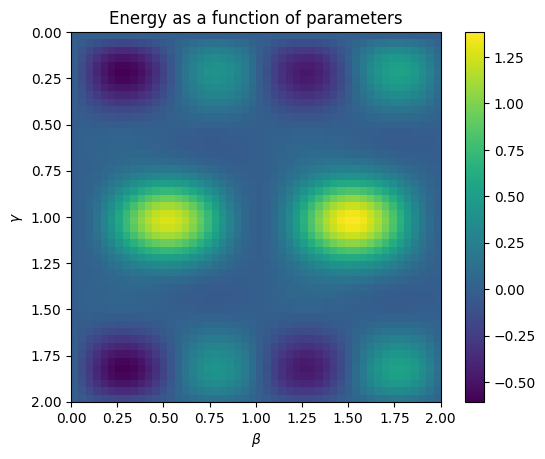

In [32]:
"""Plot the energy as a function of the parameters 𝛄 and β found in the grid search."""
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")
plt.title("Energy as a function of parameters")
plt.imshow(energies, extent=(0, beta_max, gamma_max, 0))
plt.colorbar()
plt.show()

We see that the energy function has a number of interesting properties. First, note that the function is periodic in $\beta$ and $\gamma$ with shorter periods than one might naively expect given the definition of the gates. The details of why that's true will take us away from the main content of this tutorial, but it's a good thing to understand so that the parameter space can be efficiently truncated.

The other main thing to notice is that there are many local minima and maxima. This makes it challenging to use gradient-based methods for optimization, which we'll explicitly see next. Part of the challenge for algorithms of this type is finding efficient ways to optimize the parameters.

#### Gradient descent

For practice let's try to minimize the expectation value of the energy using gradient descent. We know that there are local minima that we might get stuck in, depending on initialization, but it's still a worthwhile exercise.

The first step is to define a function which approximates the gradient of the energy. We'll do this by symmetric difference, i.e., $f'(x) \approx (f(x+\epsilon)-f(x-\epsilon))/(2\epsilon)$. You should experiment with different values of $\epsilon$ as well as different formulas for the gradient. 

In [18]:
def gradient_energy(
    gamma: float, beta: float, qaoa: cirq.Circuit, h: np.ndarray
) -> Tuple[float, float]:
    """Uses a symmetric difference to calculate the gradient."""
    eps = 10**-3  # Try different values of the discretization parameter

    # Gamma-component of the gradient
    grad_g = energy_from_params(gamma + eps, beta, qaoa, h)
    grad_g -= energy_from_params(gamma - eps, beta, qaoa, h)
    grad_g /= 2 * eps

    # Beta-compoonent of the gradient
    grad_b = energy_from_params(gamma, beta + eps, qaoa, h)
    grad_b -= energy_from_params(gamma, beta - eps, qaoa, h)
    grad_b /= 2 * eps

    return grad_g, grad_b

Now we'll implement a gradient descent algorithm that minimizes the energy. Note that it will get stuck in local minima depending on the initialization.

In [19]:
"""Run a simple gradient descent optimizer."""
gamma, beta = 0.2, 0.7  # Try different initializations
eta = 10**-2  # Try adjusting the learning rate.

# Perform gradient descent for a given number of steps.
num_steps = 150
for i in range(num_steps + 1):
    # Compute the gradient.
    grad_g, grad_b = gradient_energy(gamma, beta, qaoa, h)

    # Update the parameters.
    gamma -= eta * grad_g
    beta -= eta * grad_b

    # Status updates.
    if not i % 25:
        print("Step: {} Energy: {}".format(i, energy_from_params(gamma, beta, qaoa, h)))

print("\nLearned gamma: {}\nLearned beta: {}".format(gamma, beta, qaoa, h))

Step: 0 Energy: 0.35551818400921953
Step: 25 Energy: -0.6065682037739306
Step: 50 Energy: -0.6068782208686925
Step: 75 Energy: -0.6068782576010108
Step: 100 Energy: -0.6068782110887696
Step: 125 Energy: -0.6068782176487275
Step: 150 Energy: -0.6068782556047962

Learned gamma: 0.19753251184032644
Learned beta: 0.2684372230510191


### Getting the approximate solutions

We've optimized our parameters. How well did we do?

For a $3\times 3$ grid we have $9$ qubits and $12$ interacting nearest-neighbor pairs. If all of the qubits are in the $|0\rangle$ state or all are in the $|1\rangle$ state, then the energy-per-qubit is $-12/9 = -1.33$ at zero external magnetic field $h$, and will be close to that if the magnetic field is small. Notice that the QAOA algorithm we analyzed above is __not__ getting close to that ground state. Is this a problem?

Well, not really. The QAOA algorithm still succeeds if we can  find the ground state after a small number of measurements. The QAOA prepares a certain state which is a linear combination of the ground state and many other states. When we measure the qubits, we find the ground-state configuration with some probability. If that probability is relatively large, then after a reasonably small number of measurements we'll locate the ground state.

Practically speaking, this means we should measure the state prepared by the QAOA several times and record the lowest-energy state we find. The QAOA can be successful by biasing these measurements toward the ground state, even if they do not produce the ground state with $100\%$ probability.

Let's make a copy of our qaoa circuit for measurement purposes and attach a measurement gate to each qubit.

In [20]:
"""Add measurements to the QAOA circuit."""
measurement_circuit = qaoa.copy()
measurement_circuit.append(
    cirq.measure(*[qubit for row in qubits for qubit in row], key="m")
)
measurement_circuit

┌──────────────────┐               ┌──────────────────┐
(0, 0): ───H───ZZ───────ZZ───────Z^(0.5*𝛄)──────────────────────────────────────────────────────────────────────────────────────────────X^(β)───M('m')───
               │        │                                                                                                                       │
(0, 1): ───H───┼────────ZZ^(𝛄)───ZZ──────────ZZ────────Z^(0.5*𝛄)────────────────────────────────────────────────────────────────────────X^(β)───M────────
               │                 │           │                                                                                                  │
(0, 2): ───H───┼─────────────────┼───────────ZZ^(𝛄)────ZZ────────────────────Z^(0.5*𝛄)──────────────────────────────────────────────────X^(β)───M────────
               │                 │                     │                                                                                        │
(1, 0): ───H───ZZ^(𝛄)───ZZ───────┼───────────ZZ────────┼────────Z^(0.5*𝛄)───────────────────────────────────────────────────────────────X^(β)───M────────
                        │        │           │         │                                                                                        │
(1, 1): ───H────────────┼────────ZZ^(𝛄)──────ZZ^(𝛄)────┼────────ZZ───────────ZZ───────────Z^(0.5*𝛄)─────────────────────────────────────X^(β)───M────────
                        │                              │        │            │                                                                  │
(1, 2): ───H────────────┼──────────────────────────────ZZ^(𝛄)───┼────────────ZZ^(𝛄)───────ZZ────────────────────Z^(0.5*𝛄)───────────────X^(β)───M────────
                        │                                       │                         │                                                     │
(2, 0): ───H────────────ZZ^(𝛄)──────────────────────────────────┼────────────ZZ───────────┼────────Z^(0.5*𝛄)────────────────────────────X^(β)───M────────
                                                                │            │            │                                                     │
(2, 1): ───H────────────────────────────────────────────────────ZZ^(𝛄)───────ZZ^(𝛄)───────┼─────────────────────ZZ──────────Z^(0.5*𝛄)───X^(β)───M────────
                                                                                          │                     │                               │
(2, 2): ───H──────────────────────────────────────────────────────────────────────────────ZZ^(𝛄)────────────────ZZ^(𝛄)──────Z^(0.5*𝛄)───X^(β)───M────────
                                                      └──────────────────┘               └──────────────────┘

Now we'll measure the output of the circuit repeatedly for a good set of angles $\gamma$ and $\beta$. Note that these are simply found from inspecting the above heatmap of the energy found via grid search.

In [21]:
"""Sample from the QAOA circuit."""
num_reps = 1000  # Try different numbers of repetitions.
gamma_value, beta_value = 0.2, 0.25  # Try different values of the parameters.

# Sample from the circuit.
simulator = cirq.Simulator()
params = cirq.ParamResolver({"𝛄": gamma_value, "β": beta_value})
result = simulator.run(measurement_circuit, param_resolver=params, repetitions=num_reps)

Finally, we'll compute the energy for each of our measurement outcomes and look at the statistics. We start with a helper function which calculates the energy given a set of measurement outcomes.

In [22]:
def compute_energy(meas: np.ndarray) -> float:
    """Returns the energy computed from measurements.

    Args:
        meas: Measurements/samples.
    """
    Z_vals = 1 - 2 * meas.reshape(n_rows, n_cols)
    energy = 0
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows - 1:
                energy -= Z_vals[i, j] * Z_vals[i + 1, j]
            if j < n_cols - 1:
                energy -= Z_vals[i, j] * Z_vals[i, j + 1]
            energy -= h[i, j] * Z_vals[i, j]
    return energy / (n_rows * n_cols)

Now we consider the 10 most common outputs of our measurements and compute the energies of those.

In [23]:
"""Compute the energies of the most common measurement results."""
# Get a histogram of the measurement results.
hist = result.histogram(key="m")

# Consider the top 10 of them.
num = 10

# Get the most common measurement results and their probabilities.
configs = [c for c, _ in hist.most_common(num)]
probs = [v / result.repetitions for _, v in hist.most_common(num)]

We can now plot the probabilities of the most common measurement results as well as the energies associated with these results.

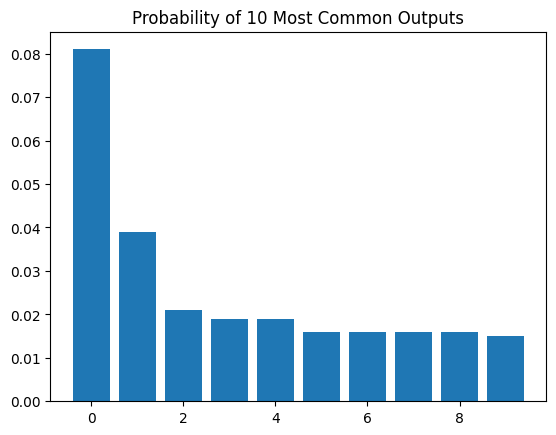

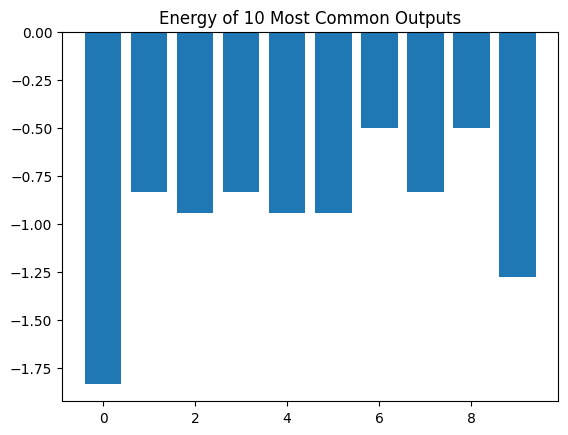

Fraction of outputs displayed: 0.26


In [24]:
"""Plot the most common measurement results and their energies."""
# Plot probabilities of the most common bitstrings.
plt.title("Probability of {} Most Common Outputs".format(num))
plt.bar([x for x in range(len(probs))], probs)
plt.show()
meas = [
    [int(s) for s in "".join([str(b) for b in bin(k)[2:]]).zfill(n_rows * n_cols)]
    for k in configs
]
costs = [compute_energy(np.array(m)) for m in meas]

# Plot energies of the most common bitstrings.
plt.title("Energy of {} Most Common Outputs".format(num))
plt.bar([x for x in range(len(costs))], costs)
plt.show()
print("Fraction of outputs displayed: {}".format(np.sum(probs).round(2)))

We see that, for a good choice of $\gamma$ and $\beta$, ground state is the most probable outcome.

Try changing the values of $\gamma$ and $\beta$ away from the optimal ones. You'll see that this experiment no longer finds the ground state for us.

### Exercise: Experiment with different numbers of layers

See if you can get a closer to the true ground state (i.e. a larger fraction of measurements yielding the minimal energy) by adding more layers to the circuit.

### Exercise: Try a different graph and/or different interaction strengths

Instead of a square lattice, you can try to formulate the Ising model on any graph you like. This just changes which qubits you link in the $U(\gamma, C)$ layer. Each edge of the graph could also come with a different interaction coefficient, so that instead of $\exp(i\pi \gamma Z_i Z_j/2)$ for that edge you would have $\exp(i\pi \gamma J_{ij} Z_i Z_j / 2)$ for some matrix $J_{ij}$ of coefficients. Note that you have to change both the $U(\gamma, C)$ layer and the definition of the energy function to make this work.

### Exercise: Repeat using sampling

On real hardware, we need to use sampling to estimate expectation values. Adjust your code so that sampling is used instead of wavefunction evaluation. How many samples do you need to take to get good results? Try different values.

### Exercise: Transverse field Ising model

The Ising Model with transverse field replaces the $\sum h_i Z_i$ term with a $\sum h_i X_i$ term. Can we use the QAOA here as well? What are the differences? This is no longer a classical problem: in general the ground state will now be a superposition of elements of the computational basis. Can you make a circuit that prepares a state close to the ground state?